In [147]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats as stats
from imblearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImPipeline
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [173]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Ridge,LogisticRegression
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures,LabelEncoder
from imblearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImPipeline

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV,cross_validate
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.metrics import recall_score,accuracy_score, precision_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import SMOTE
from sklearn.metrics import log_loss
from sklearn.metrics import RocCurveDisplay
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest

In [149]:
df_test = pd.read_csv('Data/Loan_Default_test_cleaned.csv', index_col=0)

In [182]:
df_test.shape

(34172, 36)

In [151]:
df_test.head()

,Interest_rate_spread,rate_of_interest,LTV,Upfront_charges%,dtir1,loan_limit,year,Gender,approv_in_adv,loan_type,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,Region,Security_Type,monthly_premium,PTI,Status
ID,,,,,,,,,,,,,,,,,,,,,
24890,0.441418,3.990,98.728814,0.009923,45,cf,2019,Sex Not Available,nopre,type1,...,EXP,758,CIB,25-34,to_inst,south,direct,555.517392,0.319263,1
24894,0.304200,4.000,91.886544,0.000000,39,cf,2019,Joint,pre,type1,...,CRIF,602,EXP,25-34,not_inst,North,direct,3325.197533,0.318506,0
24902,0.441418,3.990,80.038760,0.009923,51,cf,2019,Joint,nopre,type2,...,CRIF,884,EXP,65-74,to_inst,North,direct,984.672458,0.260495,1
24910,0.283700,2.990,54.928315,0.034160,6,cf,2019,Joint,nopre,type1,...,EXP,668,EXP,65-74,to_inst,North,direct,2115.158941,0.125454,0
24913,0.045400,3.625,62.303150,0.021049,44,cf,2019,Female,nopre,type1,...,CIB,620,CIB,65-74,not_inst,south,direct,1443.402371,0.522972,0


In [152]:
df_train = pd.read_csv('Data/Loan_Default_train_cleaned.csv', index_col=0)

In [153]:
df_train.shape

(102501, 36)

C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


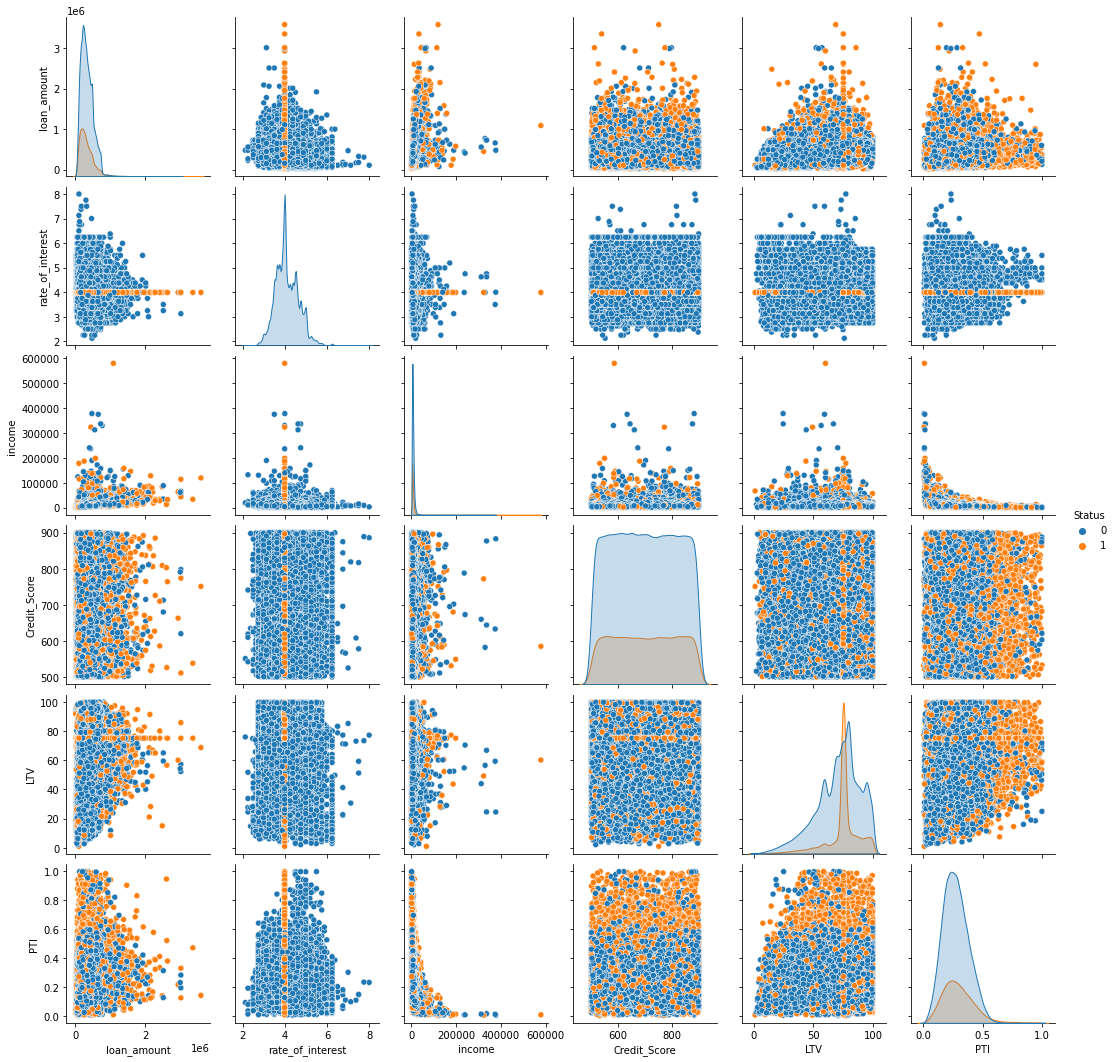

In [4]:
data_temp = df[['loan_amount','rate_of_interest','income','Credit_Score','LTV','PTI','Status']]
sns.pairplot(data_temp, hue="Status",height=2.5);
plt.show();

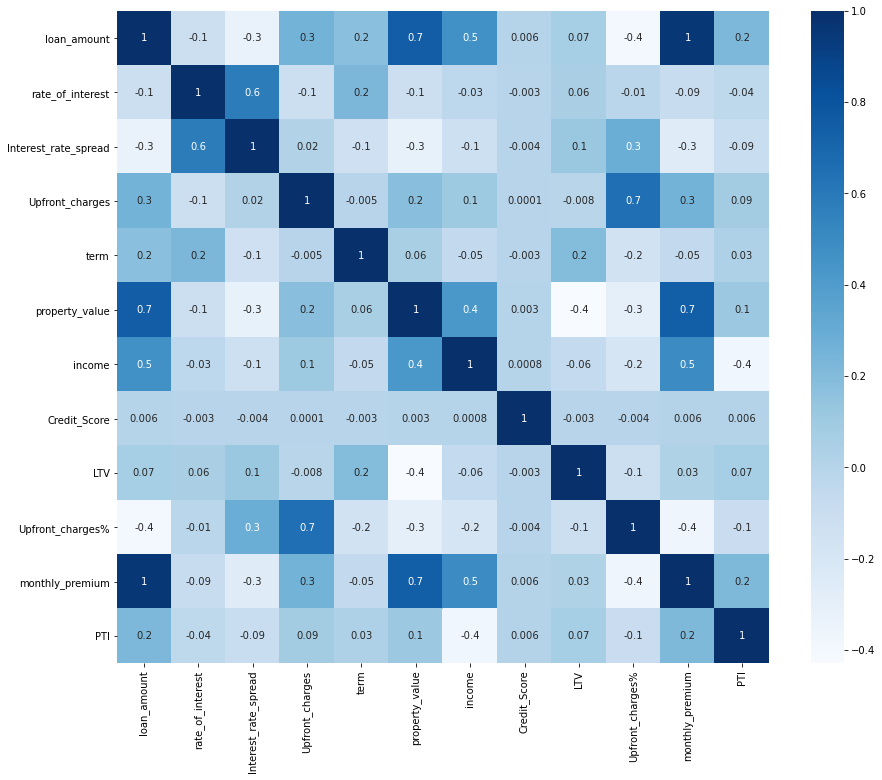

In [8]:
corr_mat = df[['loan_amount','rate_of_interest','Interest_rate_spread','Upfront_charges','term','property_value','income','Credit_Score','LTV','Upfront_charges%','monthly_premium','PTI']].corr()
mask = np.triu(np.ones_like(corr_mat, dtype=bool))
plt.subplots(figsize=(15,12))
sns.heatmap(corr_mat, annot=True, cmap='Blues', square=True,fmt='.0g');
plt.xticks(rotation=90);
plt.yticks(rotation=0);

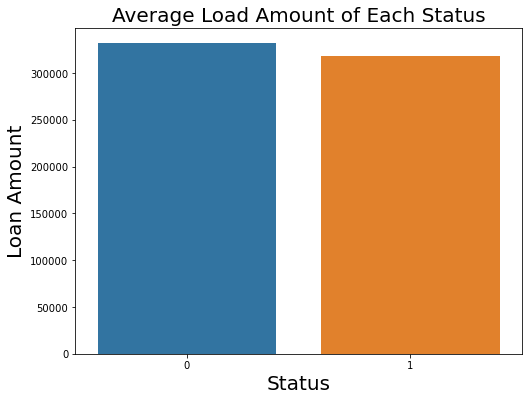

In [5]:
df_snla = df[['Status', 'loan_amount']]
snla = df_snla.groupby('Status').mean() 
snla['Status'] = [0,1]
plt.figure(figsize = (8,6))
ax = sns.barplot(x = 'Status', y = 'loan_amount',data = snla)
ax.set_xlabel("Status", fontsize = 20)
ax.set_ylabel('Loan Amount', fontsize = 20)
ax.set_title("Average Load Amount of Each Status", fontsize = 20)

plt.show()

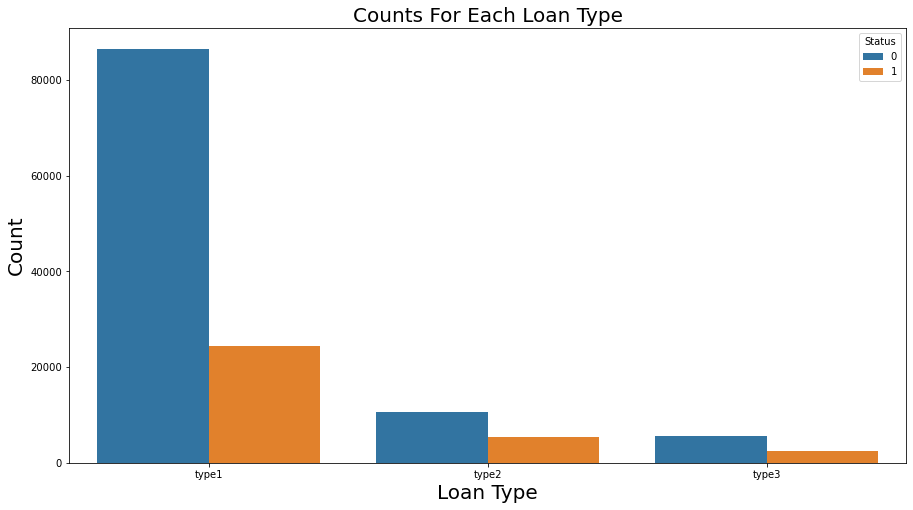

In [6]:
df_lts = df[['loan_type', 'Status']]
lts_0 = df_lts.groupby(['loan_type']).apply(lambda x: x[x['Status'] == 0 ]['Status'].count())
lts_1 = df_lts.groupby(['loan_type']).apply(lambda x: x[x['Status'] == 1 ]['Status'].count())
lts0 = lts_0.to_frame(name = '0')
lts1 = lts_1.to_frame(name = '1')
lts = pd.concat([lts0,lts1], axis = 1)
lts['loan_type'] = sorted(df_lts['loan_type'].unique())
lts_melt = pd.melt(lts, id_vars="loan_type", var_name="Status", value_name="count")
plt.figure(figsize = (15,8))
ax = sns.barplot(x="loan_type", y="count", hue="Status", data=lts_melt)
ax.set_xlabel("Loan Type", fontsize = 20)
ax.set_ylabel('Count', fontsize = 20)
ax.set_title("Counts For Each Loan Type", fontsize = 20)
plt.show()

In [77]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101387 entries, 148781 to 146848
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   loan_limit                 101387 non-null  object 
 1   Gender                     101387 non-null  object 
 2   approv_in_adv              101387 non-null  object 
 3   loan_type                  101387 non-null  object 
 4   loan_purpose               101387 non-null  object 
 5   Credit_Worthiness          101387 non-null  object 
 6   open_credit                101387 non-null  object 
 7   business_or_commercial     101387 non-null  object 
 8   loan_amount                101387 non-null  int64  
 9   rate_of_interest           101387 non-null  float64
 10  Interest_rate_spread       101387 non-null  float64
 11  Upfront_charges            101387 non-null  float64
 12  term                       101387 non-null  float64
 13  Neg_ammortization       

In [78]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33804 entries, 49802 to 41080
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   loan_limit                 33804 non-null  object 
 1   Gender                     33804 non-null  object 
 2   approv_in_adv              33804 non-null  object 
 3   loan_type                  33804 non-null  object 
 4   loan_purpose               33804 non-null  object 
 5   Credit_Worthiness          33804 non-null  object 
 6   open_credit                33804 non-null  object 
 7   business_or_commercial     33804 non-null  object 
 8   loan_amount                33804 non-null  int64  
 9   rate_of_interest           33804 non-null  float64
 10  Interest_rate_spread       33804 non-null  float64
 11  Upfront_charges            33804 non-null  float64
 12  term                       33804 non-null  float64
 13  Neg_ammortization          33804 non-null 

In [154]:
numcols = ['loan_amount','rate_of_interest','Interest_rate_spread','Upfront_charges','term','property_value','income','Credit_Score','LTV','Upfront_charges%','monthly_premium','PTI']

In [155]:
catcols = ['loan_limit','Gender','approv_in_adv','loan_type','loan_purpose','Credit_Worthiness','open_credit','business_or_commercial','Neg_ammortization','interest_only','lump_sum_payment','construction_type','occupancy_type','Secured_by','total_units', 'credit_type', 'co-applicant_credit_type','age','submission_of_application','Region','Security_Type']

In [156]:
#from sklearn.model_selection import train_test_split
#X = df.drop('Status', axis =1)
#y = df['Status']

#X_train, X_test, y_train, y_test = train_test_split(X,y,random_state =42,test_size = 0.25)

In [157]:
X_train = df_train.drop(['Status'],axis=1) 
X_test = df_test.drop(['Status'],axis=1)
y_train = df_train['Status']
y_test = df_test['Status']

In [158]:
subpipe_numerics =Pipeline(steps =[
    ('ss',StandardScaler())      
])
    
subpipe_cat =Pipeline([
    ('ohe',OneHotEncoder(sparse=False, handle_unknown='ignore')) 
])

In [159]:
CT = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_numerics,numcols),
    ('subpipe_cate', subpipe_cat,catcols)  
],remainder='drop')

In [160]:
subpipe_numerics1 =Pipeline(steps =[
    ('polynomial',PolynomialFeatures()),
    ('ss',StandardScaler())
])
    
subpipe_cat1 =Pipeline([
    ('ohe',OneHotEncoder(sparse=False, handle_unknown='ignore')) 
])

In [161]:
CT_poly = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_numerics1,numcols),
    ('subpipe_cate', subpipe_cat1,catcols)
],remainder='drop')

In [162]:
CT_poly

ColumnTransformer(transformers=[('subpipe_num',
                                 Pipeline(steps=[('polynomial',
                                                  PolynomialFeatures()),
                                                 ('ss', StandardScaler())]),
                                 ['loan_amount', 'rate_of_interest',
                                  'Interest_rate_spread', 'Upfront_charges',
                                  'term', 'property_value', 'income',
                                  'Credit_Score', 'LTV', 'Upfront_charges%',
                                  'monthly_premium', 'PTI']),
                                ('subpipe_cate',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncode...
                                                                sparse=False))]),
                                 ['loan_limit', 'Gender', 'approv_in_adv',
                                  'loan_type', 'loan_purpose',
                                  'Credit_Worthiness', 'open_credit',
                                  'business_or_commercial', 'Neg_ammortization',
                                  'interest_only', 'lump_sum_payment',
                                  'construction_type', 'occupancy_type',
                                  'Secured_by', 'total_units', 'credit_type',
                                  'co-applicant_credit_type', 'age',
                                  'submission_of_application', 'Region',
                                  'Security_Type'])])

In [163]:
def model_eval(estimator,X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,CT=CT):
    warnings.filterwarnings('ignore')
    model_name = type(estimator).__name__
    model = Pipeline(steps=[
    ('ct',CT),
    ('model',estimator)])

    model.fit(X_train,y_train)
    
    print(f'below are the model evaluation statistics of {model}')
    print(f' train_score : {round(model.score(X_train,y_train),4)}')
    print(f' test_score : {round(model.score(X_test,y_test),4)}')
    print(f' log loss on training dataset : {round(log_loss(y_train, model.predict_proba(X_train)),4)}')
    print(f' log loss on test dataset : {round(log_loss(y_test, model.predict_proba(X_test)),4)}')
    print(f'CrossValidation on training dataset : {cross_val_score(model,X_train,y_train,scoring="f1").mean()}')
    
    print('classification_report')
    print(classification_report(y_test, model.predict(X_test)))
    
    cm = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    cm.ax_.set_title('Conf Matrix on Test Data')
    
    RocCurveDisplay.from_estimator(model, X_test, y_test)

below are the model evaluation statistics of Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['loan_amount',
                                                   'rate_of_interest',
                                                   'Interest_rate_spread',
                                                   'Upfront_charges', 'term',
                                                   'property_value', 'income',
                                                   'Credit_Score', 'LTV',
                                                   'Upfront_charges%',
                                                   'monthly_premium', 'PTI']),
                                                 ('subpipe_cate',
                                               

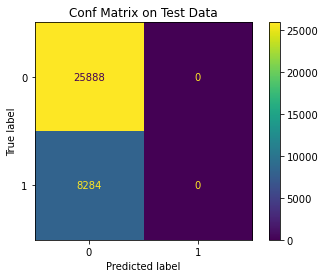

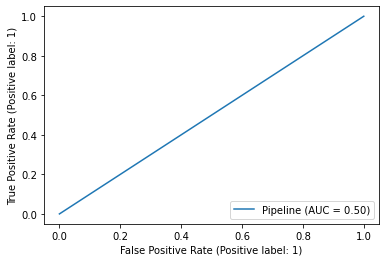

In [167]:
model_eval(DummyClassifier())

below are the model evaluation statistics of Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['loan_amount',
                                                   'rate_of_interest',
                                                   'Interest_rate_spread',
                                                   'Upfront_charges', 'term',
                                                   'property_value', 'income',
                                                   'Credit_Score', 'LTV',
                                                   'Upfront_charges%',
                                                   'monthly_premium', 'PTI']),
                                                 ('subpipe_cate',
                                               

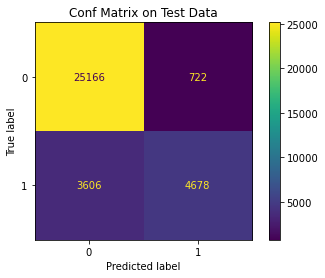

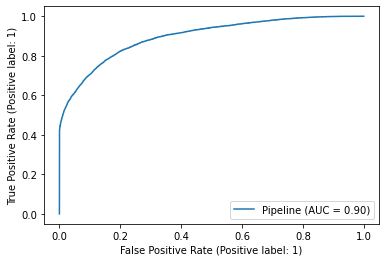

In [168]:
model_eval(LogisticRegression())

below are the model evaluation statistics of Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('polynomial',
                                                                   PolynomialFeatures()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['loan_amount',
                                                   'rate_of_interest',
                                                   'Interest_rate_spread',
                                                   'Upfront_charges', 'term',
                                                   'property_value', 'income',
                                                   'Credit_Score', 'LTV',
                                                   'Upfront_charges%',
                     

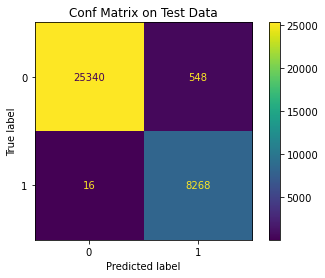

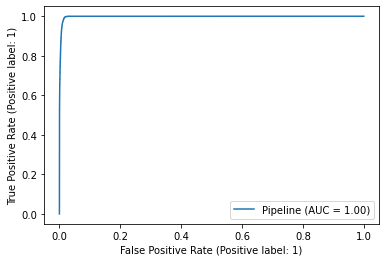

In [169]:
model_eval(LogisticRegression(),CT=CT_poly)

below are the model evaluation statistics of Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['loan_amount',
                                                   'rate_of_interest',
                                                   'Interest_rate_spread',
                                                   'Upfront_charges', 'term',
                                                   'property_value', 'income',
                                                   'Credit_Score', 'LTV',
                                                   'Upfront_charges%',
                                                   'monthly_premium', 'PTI']),
                                                 ('subpipe_cate',
                                               

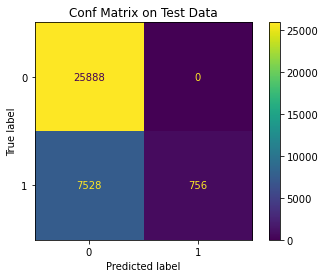

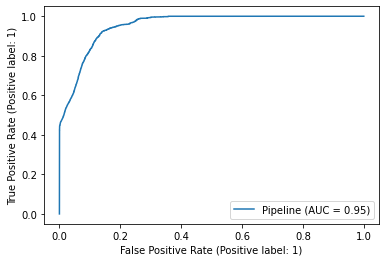

In [170]:
model_eval(RandomForestClassifier(max_depth=3))

In [177]:
pipeline = Pipeline([
    ('ct',CT),
    ('feature_selection', SelectKBest(k=min(5, X_train.shape[1]))),
    ('model', RandomForestClassifier())

])

# Fit the pipeline on your data
pipeline.fit(X_train, y_train)

# Extract feature importance
feature_importance = pipeline.named_steps['model'].feature_importances_

# Get the selected feature indices
selected_feature_indices = pipeline.named_steps['feature_selection'].get_support(indices=True)

if len(selected_feature_indices) > 0:
    # Get the corresponding feature names
    feature_names = [X_train.columns[i] for i in selected_feature_indices]

    # Print feature importance and corresponding feature names
    for name, importance in zip(feature_names, feature_importance):
        print(f"{name}: {importance}")
else:
    print("No features were selected.")

IndexError: index 37 is out of bounds for axis 0 with size 35

below are the model evaluation statistics of Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['loan_amount',
                                                   'rate_of_interest',
                                                   'Interest_rate_spread',
                                                   'Upfront_charges', 'term',
                                                   'property_value', 'income',
                                                   'Credit_Score', 'LTV',
                                                   'Upfront_charges%',
                                                   'monthly_premium', 'PTI']),
                                                 ('subpipe_cate',
                                               

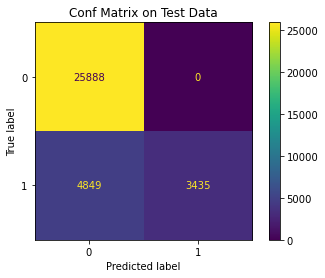

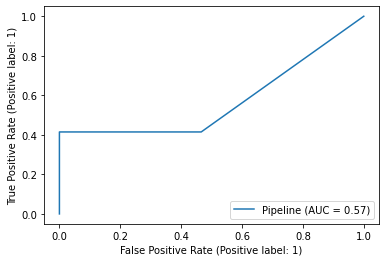

In [181]:
model_eval(DecisionTreeClassifier(max_depth=2))

In [49]:
model = Pipeline(steps=[
    ('ct',CT),
    ('model',DecisionTreeClassifier())])

model.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['loan_amount',
                                                   'rate_of_interest',
                                                   'Interest_rate_spread',
                                                   'Upfront_charges', 'term',
                                                   'property_value', 'income',
                                                   'Credit_Score', 'LTV',
                                                   'Upfront_charges%',
                                                   'monthly_premium', 'PTI']),
                                                 ('subpipe_cate',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unkno...
                                                   'approv_in_adv', 'loan_type',
                                                   'loan_purpose',
                                                   'Credit_Worthiness',
                                                   'open_credit',
                                                   'business_or_commercial',
                                                   'Neg_ammortization',
                                                   'interest_only',
                                                   'lump_sum_payment',
                                                   'construction_type',
                                                   'occupancy_type',
                                                   'Secured_by', 'total_units',
                                                   'credit_type',
                                                   'co-applicant_credit_type',
                                                   'age',
                                                   'submission_of_application',
                                                   'Region',
                                                   'Security_Type'])])),
                ('model', DecisionTreeClassifier())])

In [65]:
model.name

AttributeError: 'Pipeline' object has no attribute 'name'

In [52]:
model.score(X_test,y_test)

0.8641580878002604

In [60]:
feature_used = list(df_train.columns.values)

In [64]:
model_tree = model.named_steps['model']
feature_names = model.named_steps['ct'].get_feature_names_out(input_features=feature_used)

f, ax = plt.subplots(figsize=(12, 12))
tree.plot_tree(model_tree, feature_names=feature_names, ax=ax)

AttributeError: 'ColumnTransformer' object has no attribute 'get_feature_names'

In [66]:
feature_used

['Unnamed: 0.1',
 'ID',
 'loan_limit',
 'Gender',
 'approv_in_adv',
 'loan_type',
 'loan_purpose',
 'Credit_Worthiness',
 'open_credit',
 'business_or_commercial',
 'loan_amount',
 'rate_of_interest',
 'Interest_rate_spread',
 'Upfront_charges',
 'term',
 'Neg_ammortization',
 'interest_only',
 'lump_sum_payment',
 'property_value',
 'construction_type',
 'occupancy_type',
 'Secured_by',
 'total_units',
 'income',
 'credit_type',
 'Credit_Score',
 'co-applicant_credit_type',
 'age',
 'submission_of_application',
 'LTV',
 'Region',
 'Security_Type',
 'Status',
 'Upfront_charges%',
 'monthly_premium',
 'PTI']

below are the model evaluation statistics of Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['loan_amount',
                                                   'rate_of_interest',
                                                   'Interest_rate_spread',
                                                   'Upfront_charges', 'term',
                                                   'property_value', 'income',
                                                   'Credit_Score', 'LTV',
                                                   'Upfront_charges%',
                                                   'monthly_premium', 'PTI']),
                                                 ('subpipe_cate',
                                               

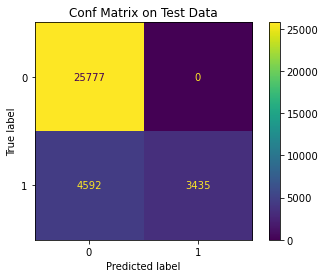

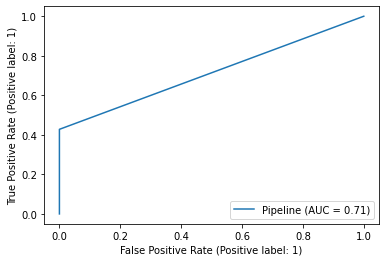

In [129]:
model_eval(GradientBoostingClassifier())

below are the model evaluation statistics of Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['loan_amount',
                                                   'rate_of_interest',
                                                   'Interest_rate_spread',
                                                   'Upfront_charges', 'term',
                                                   'property_value', 'income',
                                                   'Credit_Score', 'LTV',
                                                   'Upfront_charges%',
                                                   'monthly_premium', 'PTI']),
                                                 ('subpipe_cate',
                                               

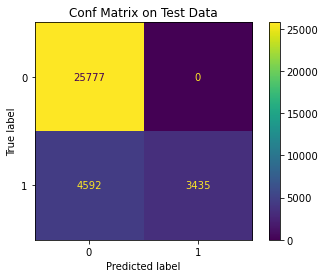

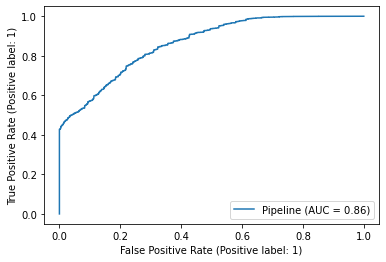

In [28]:
model_eval(XGBClassifier())

In [136]:
fsm_model_pipe1= ImPipeline(steps=[
        ('ct',CT),
        ('smote',SMOTE(random_state=42)),
        ('fsm',RandomForestClassifier(max_depth=3))
    ])

In [137]:
fsm_model_pipe1.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['loan_amount',
                                                   'rate_of_interest',
                                                   'Interest_rate_spread',
                                                   'Upfront_charges', 'term',
                                                   'property_value', 'income',
                                                   'Credit_Score', 'LTV',
                                                   'Upfront_charges%',
                                                   'monthly_premium', 'PTI']),
                                                 ('subpipe_cate',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unkno...
                                                   'Credit_Worthiness',
                                                   'open_credit',
                                                   'business_or_commercial',
                                                   'Neg_ammortization',
                                                   'interest_only',
                                                   'lump_sum_payment',
                                                   'construction_type',
                                                   'occupancy_type',
                                                   'Secured_by', 'total_units',
                                                   'credit_type',
                                                   'co-applicant_credit_type',
                                                   'age',
                                                   'submission_of_application',
                                                   'Region',
                                                   'Security_Type'])])),
                ('smote', SMOTE(random_state=42)),
                ('fsm', RandomForestClassifier(max_depth=3))])

In [138]:
log_train_score = round(fsm_model_pipe1.score(X_train,y_train),4)
log_train_score

0.9922

In [139]:
log_test_score = round(fsm_model_pipe1.score(X_test,y_test),4)
log_test_score

0.8625

In [140]:
log_log_loss_train = round(log_loss(y_train, fsm_model_pipe1.predict_proba(X_train)),4)
log_log_loss_test = round(log_loss(y_test, fsm_model_pipe1.predict_proba(X_test)),4)

print(f"""
Our fsm model's logloss on the train set is {log_log_loss_train}. \n
Our fsm model's logloss on the test set is {log_log_loss_test}

""")


Our fsm model's logloss on the train set is 0.3457. 

Our fsm model's logloss on the test set is 0.4347




In [141]:
log_cv = cross_val_score(fsm_model_pipe1, X_train, y_train,scoring = "f1")
log_cv= round(log_cv.mean(),4)
log_cv

0.9781

In [142]:
y_hat = fsm_model_pipe1.predict(X_test)
log_accuracy = round(accuracy_score(y_test, y_hat), 2)
log_recall = round(recall_score(y_test, y_hat), 2)
log_precision = round(precision_score(y_test, y_hat), 2)
log_f1 = round(f1_score(y_test, y_hat), 2)

print(f"""
Our fsm model's accuracy on the test set is {log_accuracy}. \n
Our fsm model's recall on the test set is {log_recall} \n
Our fsm model's precision on the test set is {log_precision} \n
Our fsm model's f1-score on the test is {log_f1}.
""")


Our fsm model's accuracy on the test set is 0.86. 

Our fsm model's recall on the test set is 0.45 

Our fsm model's precision on the test set is 0.94 

Our fsm model's f1-score on the test is 0.61.



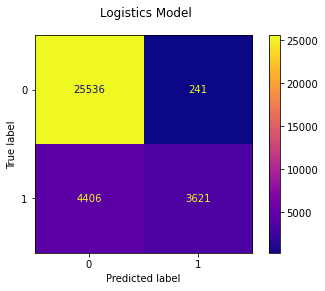

In [143]:
fig, ax = plt.subplots()

fig.suptitle("Logistics Model")

ConfusionMatrixDisplay.from_estimator(fsm_model_pipe1, X_test, y_test, ax=ax, cmap="plasma");

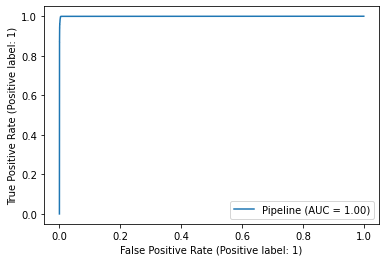

In [144]:
RocCurveDisplay.from_estimator(fsm_model_pipe1, X_train, y_train);